In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.mpradragonn_deep_factorized_model import load_saved_predictor

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


Using TensorFlow backend.


In [2]:
#Download MPRA-DragoNN models
#!wget https://github.com/kundajelab/MPRA-DragoNN/raw/master/kipoi/ConvModel/pretrained.hdf5
#!wget https://github.com/kundajelab/MPRA-DragoNN/raw/master/kipoi/DeepFactorizedModel/pretrained.hdf5


In [3]:

def get_earthmover_loss(target_output_ixs, pwm_start=0, pwm_end=70, pwm_target_bits=1.8, pwm_entropy_weight=0.0, conv_1_penalty=0.0, conv_1_margin=1.0, conv_2_penalty=0.0, conv_2_margin=1.0, conv_3_penalty=0.0, conv_3_margin=1.0) :
    
    punish_c = 0.0
    punish_g = 0.0
    
    entropy_mse = get_margin_entropy(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    punish_c_func = get_punish_c(pwm_start=pwm_start, pwm_end=pwm_end)
    punish_g_func = get_punish_g(pwm_start=pwm_start, pwm_end=pwm_end)
    
    pred_mask = np.zeros((1, 1, 12))
    pred_mask[0, 0, target_output_ixs] = 1.
    pred_mask = K.constant(pred_mask, dtype=tf.float32)
    
    n_masked = len(target_output_ixs)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        #fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        fitness_loss = -1.0 * K.sum(pred_score * pred_mask, axis=(0, -1)) / (n_masked * K.cast(K.shape(pred_score)[0], tf.float32))
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        
        entropy_loss = pwm_entropy_weight * entropy_mse(pwm)
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, pred_score = predictor_outputs

        #Specify costs
        #fitness_loss = -1.0 * K.mean(pred_score[..., 0], axis=0)
        fitness_loss = -1.0 * K.sum(pred_score * pred_mask, axis=(0, -1)) / (n_masked * K.cast(K.shape(pred_score)[0], tf.float32))
        
        seq_loss = 0.0
        seq_loss += punish_c * K.mean(punish_c_func(sampled_pwm), axis=0)
        seq_loss += punish_g * K.mean(punish_g_func(sampled_pwm), axis=0)
        
        entropy_loss = 0.0
        
        #Compute total loss
        total_loss = fitness_loss + seq_loss + entropy_loss

        return K.reshape(K.mean(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        
        self.val_loss_history.append(val_loss_value)
        
        #print("mean(" + self.val_name + ") = " + str(np.mean(val_loss_values)))

#Sequence optimization monitor during training
class StoreSequenceMonitor(Callback):
    def __init__(self, seqprop_model, sequence_encoder, run_dir="", run_prefix="", val_steps=1) :
        self.seqprop_model = seqprop_model
        self.val_steps = val_steps
        self.sequence_encoder = sequence_encoder
        self.run_prefix = run_prefix
        self.run_dir = run_dir
        self.edit_distance_samples = []
        
        if not os.path.exists(self.run_dir): os.makedirs(self.run_dir)

        seqs = self._sample_sequences()
        #self._store_sequences(seqs, 0)
    
    def _sample_sequences(self) :
        sampled_pwm = self.seqprop_model.predict(x=None, steps=self.val_steps)[2]
        
        seqs = []
        for i in range(sampled_pwm.shape[1]) :
            for j in range(sampled_pwm.shape[0]) :
                seqs.append(self.sequence_encoder.decode(sampled_pwm[j, i, :, :, 0]))
        
        return seqs
    
    def _store_sequences(self, seqs, epoch) :
        #Save sequences to file
        with open(self.run_dir + self.run_prefix + "_epoch_" + str(epoch) + "_" + str(self.val_steps) + "_steps.txt", "a+") as f:
            for i in range(len(seqs)) :
                f.write(seqs[i] + "\n")
    
    def on_epoch_end(self, epoch, logs={}) :
        
        seqs = self._sample_sequences()
        self._store_sequences(seqs, epoch)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(run_prefix, target_output_ixs_list, sequence_templates, loss_funcs, val_loss_funcs, transform_funcs, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        target_output_ixs = target_output_ixs_list[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        _, valid_generator = build_generator(seq_length=len(sequence_template), n_sequences=n_sequences, n_samples=n_valid_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='sample', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, library_context=None), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        measure_func = lambda pred_outs: np.expand_dims(np.mean(np.expand_dims(pred_outs[0][..., target_output_ixs], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0][..., target_output_ixs], axis=(0, -1)), axis=-1)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Activity', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=False, measure_func=measure_func, measure_name='Activity', plot_pwm_start=0, plot_pwm_end=145, sequence_template=sequence_template, plot_pwm_indices=np.arange(min(n_sequences, 5)).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        #Standard sequence decoder
        acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})
        
        #Build callback for printing intermediate sequences
        store_seq_monitor = StoreSequenceMonitor(valid_generator, acgt_encoder, run_dir="./samples/" + run_prefix + "/", run_prefix="intermediate", val_steps=1)

        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            valid_monitor,
            #train_history,
            #valid_history,
            store_seq_monitor
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, valid_monitors, train_histories, valid_histories


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '')
model_name = 'pretrained_deep_factorized_model.hdf5'
model_path = os.path.join(save_dir, model_name)


In [5]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


Running optimization experiment 'MPRA-DragoNN Activity Maximization'
Optimizing objective 0...
Epoch 1/100
250/250 [==============================] - 12s 50ms/step - loss: -2521.2620
Epoch 2/100
250/250 [==============================] - 11s 45ms/step - loss: -2702.6012
Epoch 3/100
250/250 [==============================] - 11s 45ms/step - loss: -2821.9306
Epoch 4/100
250/250 [==============================] - 11s 45ms/step - loss: -2921.7722
Epoch 5/100
250/250 [==============================] - 11s 45ms/step - loss: -3027.9512
Epoch 6/100
250/250 [==============================] - 11s 45ms/step - loss: -3142.5924
Epoch 7/100
250/250 [==============================] - 11s 45ms/step - loss: -3268.5997
Epoch 8/100
250/250 [==============================] - 11s 45ms/step - loss: -3398.4467
Epoch 9/100
250/250 [==============================] - 11s 45ms/step - loss: -3526.6940
Epoch 10/100
250/250 [==============================] - 11s 45ms/step - loss: -3641.9647
Epoch 11/100
250/250 [==

250/250 [==============================] - 11s 45ms/step - loss: -5344.4773
Epoch 93/100
250/250 [==============================] - 11s 45ms/step - loss: -5348.4858
Epoch 94/100
250/250 [==============================] - 11s 45ms/step - loss: -5352.6302
Epoch 95/100
250/250 [==============================] - 11s 45ms/step - loss: -5356.5756
Epoch 96/100
250/250 [==============================] - 11s 45ms/step - loss: -5360.2244
Epoch 97/100
250/250 [==============================] - 11s 45ms/step - loss: -5364.1167
Epoch 98/100
250/250 [==============================] - 11s 45ms/step - loss: -5368.0600
Epoch 99/100
250/250 [==============================] - 11s 45ms/step - loss: -5371.5646
Epoch 100/100
250/250 [==============================] - 11s 45ms/step - loss: -5375.1106


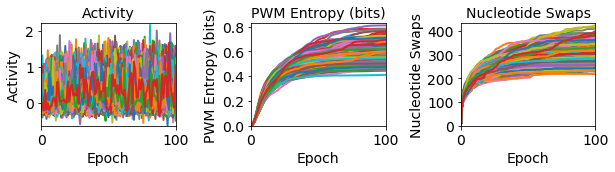

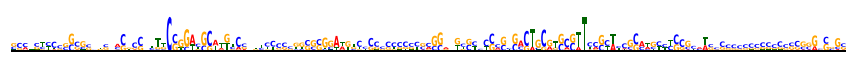

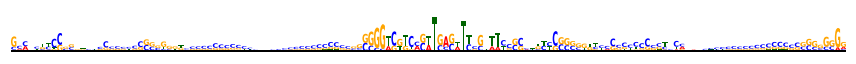

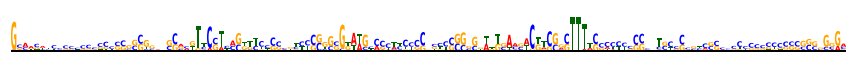

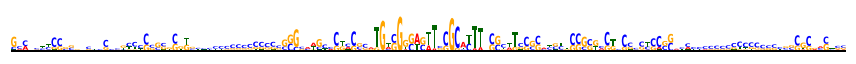

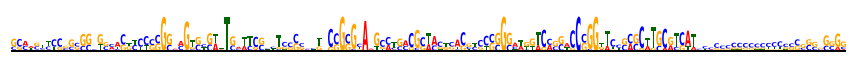

Optimizing objective 0...
Epoch 1/100
250/250 [==============================] - 12s 49ms/step - loss: -2521.5194
Epoch 2/100
250/250 [==============================] - 11s 45ms/step - loss: -2703.0705
Epoch 3/100
250/250 [==============================] - 11s 45ms/step - loss: -2821.5302
Epoch 4/100
250/250 [==============================] - 11s 45ms/step - loss: -2920.5022
Epoch 5/100
250/250 [==============================] - 11s 45ms/step - loss: -3024.3213
Epoch 6/100
250/250 [==============================] - 11s 45ms/step - loss: -3138.6989
Epoch 7/100
250/250 [==============================] - 11s 45ms/step - loss: -3264.8415
Epoch 8/100
250/250 [==============================] - 11s 45ms/step - loss: -3393.6792
Epoch 9/100
250/250 [==============================] - 11s 45ms/step - loss: -3519.0666
Epoch 10/100
250/250 [==============================] - 11s 45ms/step - loss: -3636.9260
Epoch 11/100
250/250 [==============================] - 11s 45ms/step - loss: -3742.5789
Epoc

250/250 [==============================] - 11s 45ms/step - loss: -5329.6092
Epoch 93/100
250/250 [==============================] - 11s 45ms/step - loss: -5334.6317
Epoch 94/100
250/250 [==============================] - 11s 45ms/step - loss: -5339.4295
Epoch 95/100
250/250 [==============================] - 11s 45ms/step - loss: -5343.6857
Epoch 96/100
250/250 [==============================] - 11s 45ms/step - loss: -5347.6772
Epoch 97/100
250/250 [==============================] - 11s 45ms/step - loss: -5351.5295
Epoch 98/100
250/250 [==============================] - 11s 45ms/step - loss: -5355.3922
Epoch 99/100
250/250 [==============================] - 11s 45ms/step - loss: -5359.3326
Epoch 100/100
250/250 [==============================] - 11s 45ms/step - loss: -5363.6174


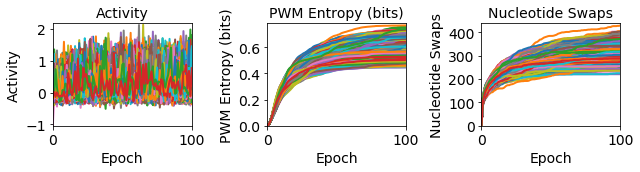

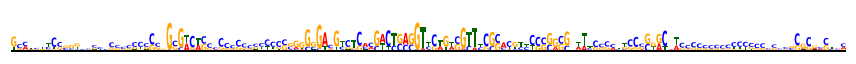

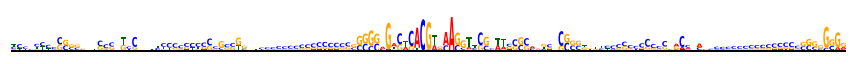

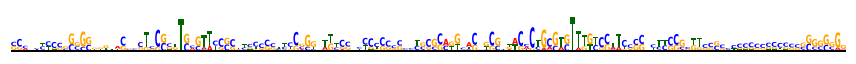

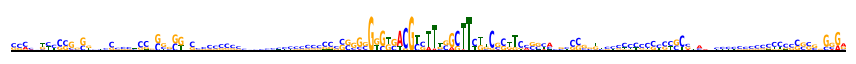

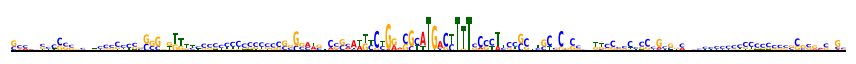

Optimizing objective 0...
Epoch 1/100
250/250 [==============================] - 12s 49ms/step - loss: -2521.1573
Epoch 2/100
250/250 [==============================] - 11s 45ms/step - loss: -2702.4510
Epoch 3/100
250/250 [==============================] - 11s 45ms/step - loss: -2821.6020
Epoch 4/100
250/250 [==============================] - 11s 45ms/step - loss: -2921.8934
Epoch 5/100
250/250 [==============================] - 11s 45ms/step - loss: -3028.9011
Epoch 6/100
250/250 [==============================] - 11s 45ms/step - loss: -3141.9581
Epoch 7/100
250/250 [==============================] - 11s 45ms/step - loss: -3265.1704
Epoch 8/100
250/250 [==============================] - 11s 45ms/step - loss: -3396.7088
Epoch 9/100
250/250 [==============================] - 11s 45ms/step - loss: -3525.4287
Epoch 10/100
250/250 [==============================] - 11s 45ms/step - loss: -3643.5254
Epoch 11/100
250/250 [==============================] - 11s 45ms/step - loss: -3749.1537
Epoc

250/250 [==============================] - 11s 45ms/step - loss: -5347.1537
Epoch 93/100
250/250 [==============================] - 11s 45ms/step - loss: -5351.6524
Epoch 94/100
250/250 [==============================] - 12s 46ms/step - loss: -5355.9480
Epoch 95/100
250/250 [==============================] - 11s 45ms/step - loss: -5360.3493
Epoch 96/100
250/250 [==============================] - 11s 45ms/step - loss: -5364.5247
Epoch 97/100
250/250 [==============================] - 11s 45ms/step - loss: -5368.5029
Epoch 98/100
250/250 [==============================] - 11s 45ms/step - loss: -5372.5650
Epoch 99/100
250/250 [==============================] - 11s 45ms/step - loss: -5376.6472
Epoch 100/100
250/250 [==============================] - 11s 45ms/step - loss: -5380.6341


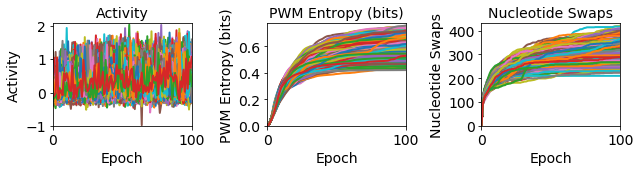

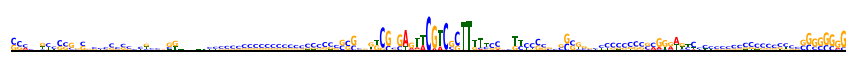

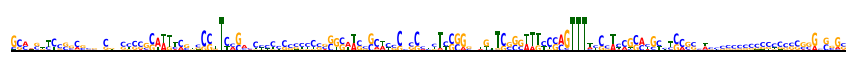

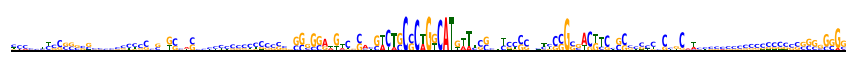

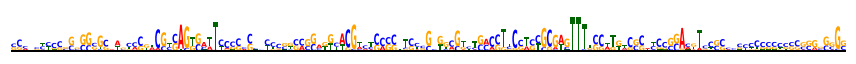

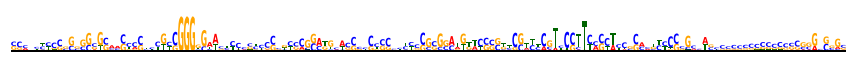

Optimizing objective 0...
Epoch 1/100
250/250 [==============================] - 12s 50ms/step - loss: -2521.3396
Epoch 2/100
250/250 [==============================] - 11s 45ms/step - loss: -2702.4428
Epoch 3/100
250/250 [==============================] - 11s 45ms/step - loss: -2821.1510
Epoch 4/100
250/250 [==============================] - 11s 45ms/step - loss: -2920.6599
Epoch 5/100
250/250 [==============================] - 11s 45ms/step - loss: -3027.3339
Epoch 6/100
250/250 [==============================] - 11s 45ms/step - loss: -3141.2440
Epoch 7/100
250/250 [==============================] - 11s 45ms/step - loss: -3267.0595
Epoch 8/100
250/250 [==============================] - 11s 45ms/step - loss: -3398.4054
Epoch 9/100
250/250 [==============================] - 11s 45ms/step - loss: -3528.0878
Epoch 10/100
250/250 [==============================] - 11s 45ms/step - loss: -3646.6686
Epoch 11/100
250/250 [==============================] - 11s 45ms/step - loss: -3749.7892
Epoc

250/250 [==============================] - 11s 45ms/step - loss: -5337.1381
Epoch 93/100
250/250 [==============================] - 11s 45ms/step - loss: -5342.5760
Epoch 94/100
250/250 [==============================] - 11s 45ms/step - loss: -5347.3470
Epoch 95/100
250/250 [==============================] - 11s 45ms/step - loss: -5351.7184
Epoch 96/100
250/250 [==============================] - 11s 45ms/step - loss: -5355.8856
Epoch 97/100
250/250 [==============================] - 11s 45ms/step - loss: -5360.2254
Epoch 98/100
250/250 [==============================] - 11s 45ms/step - loss: -5364.3086
Epoch 99/100
250/250 [==============================] - 11s 45ms/step - loss: -5368.3038
Epoch 100/100
250/250 [==============================] - 11s 45ms/step - loss: -5372.4523


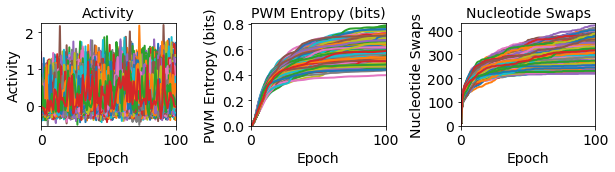

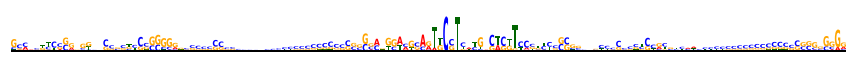

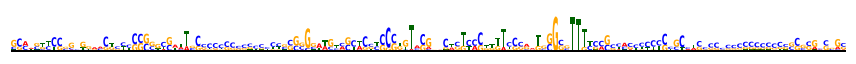

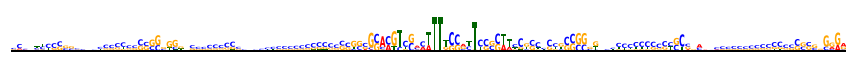

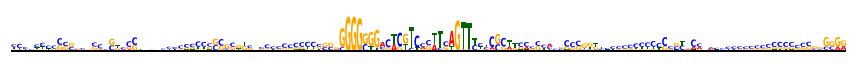

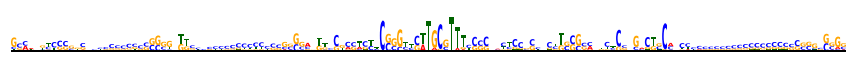

In [6]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

run_prefix = "seqprop_mpradragonn_max_activity_multi_pwm_25000_updates"

seq_template = 'N' * 145

iso_objectives = [1.0]

#rand_seed = 1177#14755

#Run SeqProp Optimization

print("Running optimization experiment 'MPRA-DragoNN Activity Maximization'")

#Number of PWMs to generate per objective
n_sequences = 4096
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Batch size per run
batch_size = 1024
#Number of epochs per objective to optimize
n_epochs = 100
#Number of steps (grad updates) per epoch
steps_per_epoch = 250
#Either 'pwm' or 'sample'
eval_mode = 'pwm'
#Normalize sequence logits
normalize_logits = False
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

n_batches = n_sequences // batch_size

acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})
optimized_seqs = []

for batch_ix in range(n_batches) :

    K.clear_session()

    #set_seed(rand_seed)

    losses, val_losses = zip(*[
        get_earthmover_loss(
            [5],
            pwm_start=0,
            pwm_end=145,
            pwm_target_bits=1.8,
            pwm_entropy_weight=0.0
        )
        for target_iso in iso_objectives
    ])

    transforms = [
        None#get_nop_transform()
        for target_iso in iso_objectives
    ]

    seqprop_predictors, valid_monitors, train_histories, valid_histories = run_seqprop(run_prefix, [[5]], sequence_templates, losses, val_losses, transforms, batch_size, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

    seqprop_predictor, valid_monitor, train_history, valid_history = seqprop_predictors[0], valid_monitors[0], train_histories[0], valid_histories[0]

    onehots = seqprop_predictor.predict(x=None, steps=1)[2][0, :, :, :, 0]
    for i in range(onehots.shape[0]) :
        optimized_seqs.append(acgt_encoder.decode(onehots[i, :, :]))


In [7]:

#Save sequences to file
with open(run_prefix + "_4096_sequences.txt", "wt") as f:
    for i in range(len(optimized_seqs)) :
        f.write(optimized_seqs[i] + "\n")
